This notebook shows how to use the imposter lightcurves to calculate metrics. The metric values used for the paper are included in `imposter_rates.csv` and `bulla_2019_rates.csv`.

In [17]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm as tqdm
import random
import os
import json
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable
import glasbey

import george
from functools import partial
import scipy.optimize as op
from astropy.table import Table, vstack
import astropy.units as u
from gaussian_process_example import *

df_imposters = pd.read_csv('imposter_gp_lightcurves_downsample.csv')
df_imposters.head()

,mjd,flux_ztfg,flux_ztfi,flux_ztfr,flux_error_ztfg,flux_error_ztfi,flux_error_ztfr,type,obj_id,mjd_0,...,mag_error_ztfg,mag_ztfr,abs_mag_ztfr,mag_error_ztfr,mag_ztfi,abs_mag_ztfi,mag_error_ztfi,t,rise,fade
0,57983.231000,385.374906,440.341788,404.940209,29.250027,17.182907,24.797305,Kilonova,AT2017gfo,57983.231,...,0.082408,17.381523,-15.832157,0.066487,17.290525,-15.923154,0.042367,0.000000,n,y
1,57983.239778,382.559484,438.232033,402.502588,28.789575,16.890215,24.361032,Kilonova,AT2017gfo,57983.231,...,0.081707,17.388078,-15.825601,0.065713,17.295740,-15.917940,0.041846,0.008778,n,y
2,57983.248556,379.738177,436.119876,400.065220,28.332873,16.606597,23.927709,Kilonova,AT2017gfo,57983.231,...,0.081009,17.394673,-15.819007,0.064937,17.300985,-15.912694,0.041343,0.017556,n,y
3,57983.257333,376.910979,434.005567,397.628148,27.879986,16.332054,23.497397,Kilonova,AT2017gfo,57983.231,...,0.080312,17.401307,-15.812372,0.064160,17.306262,-15.907418,0.040857,0.026333,n,y
4,57983.266111,374.077886,431.889351,395.191413,27.430981,16.066587,23.070161,Kilonova,AT2017gfo,57983.231,...,0.079617,17.407981,-15.805698,0.063382,17.311569,-15.902111,0.040390,0.035111,n,y


We will calculate the Full Width at Half Maximum (FWHM) and the peak magnitude of the lightcurves. The FWHM is defined as the time between the first and last points that are above half the peak value. The peak magnitude is defined as the maximum value of the lightcurve.

In [4]:
def calc_peak(df, abs=True, filters=['ztfg', 'ztfr', 'ztfi']):
    '''
    Calculates the peak magnitude in a given set of filters and returns them as a dictionary containing the time and value.
    '''
    peak_dict = {}
    for filt in filters:
        mag = f'{"abs_mag_" if abs else "mag_"}{filt}'
        if mag in df.columns:
            peak_row = df.loc[df[mag].idxmin()] if not df[mag].isnull().all() else None
            peak_dict[filt] = (peak_row['t'], peak_row[mag]) if peak_row is not None else (np.nan, np.nan)
        else:
            peak_dict[filt] = (np.nan, np.nan)
    return peak_dict


def calc_fwhm(df, abs=True, filters=['ztfg', 'ztfr', 'ztfi'], mag_diff=-2.5 * np.log10(0.5), extrapolate=True):
    '''
    Calculates the full width at half maximum in a given set of filters and returns them as dictionaries.
    '''
    fwhm_dict, rise_hwhm_dict, fade_hwhm_dict = {}, {}, {}
    peak_dict = calc_peak(df, abs=abs, filters=filters)

    for filt in filters:
        mag = f'{"abs_mag_" if abs else "mag_"}{filt}'
        if mag in df.columns:
            peak_time, peak_mag = peak_dict[filt]
            if not np.isnan(peak_time):
                half_peak = peak_mag + mag_diff
                df_filter = df[df[mag].notnull()]
                rise = df_filter[df_filter['t'] <= peak_time]
                fade = df_filter[df_filter['t'] >= peak_time]

                rise_time = rise[rise[mag] < half_peak]['t']
                fade_time = fade[fade[mag] < half_peak]['t']

                rise_hwhm = peak_time - rise_time.min() if not rise_time.empty else 0
                fade_hwhm = fade_time.max() - peak_time if not fade_time.empty else 0

                rise_hwhm_dict[filt] = rise_hwhm if rise_hwhm > 0 else np.nan
                fade_hwhm_dict[filt] = fade_hwhm if fade_hwhm > 0 else np.nan

                if rise_hwhm > 0 and fade_hwhm > 0:
                    fwhm_dict[filt] = rise_hwhm + fade_hwhm
                elif extrapolate:
                    fwhm_dict[filt] = 2 * max(rise_hwhm, fade_hwhm) if max(rise_hwhm, fade_hwhm) > 0 else np.nan
                else:
                    fwhm_dict[filt] = np.nan
            else:
                fwhm_dict[filt] = rise_hwhm_dict[filt] = fade_hwhm_dict[filt] = np.nan
        else:
            fwhm_dict[filt] = rise_hwhm_dict[filt] = fade_hwhm_dict[filt] = np.nan

    return fwhm_dict, rise_hwhm_dict, fade_hwhm_dict


In [6]:
df_rise = df_imposters[df_imposters.rise == 'y']

## identify the times of the peak in each filter for each object
df_peak = df_imposters.groupby('obj_id').apply(calc_peak)
df_peak = pd.DataFrame(df_peak.to_list(), index=df_peak.index)
df_peak = df_peak.reset_index()

for filt in ['ztfg', 'ztfr', 'ztfi']:
    df_peak[f'{filt}_peak_time'] = df_peak[f'{filt}'].apply(lambda x: x[0])
    df_peak[f'{filt}_peak_mag'] = df_peak[f'{filt}'].apply(lambda x: x[1])

    df_peak.drop(columns=[f'{filt}'], inplace=True)
df_peak.head()

,obj_id,ztfg_peak_time,ztfg_peak_mag,ztfr_peak_time,ztfr_peak_mag,ztfi_peak_time,ztfi_peak_mag
0,AT2017gfo,0.000000,-15.778388,0.000000,-15.832157,0.0,-15.923154
1,ZTF18aakuewf,3.898491,-19.662041,4.198375,-19.545710,NaN,NaN
2,ZTF18aalrxas,1.961364,-18.241097,2.059432,-17.955813,NaN,NaN
3,ZTF18abffyqp,0.950871,-17.541600,2.502293,-17.327431,NaN,NaN
4,ZTF18abvkmgw,4.277578,-17.382398,4.730358,-17.389784,NaN,NaN


In [10]:
fwhm_dict = {}
rise_hwhm_dict = {}
fade_hwhm_dict = {}
for obj in df_imposters.obj_id.unique():
    df_imposters_obj = df_imposters[df_imposters.obj_id == obj]
    fwhm_dict[obj], rise_hwhm_dict[obj], fade_hwhm_dict[obj] = calc_fwhm(df_imposters_obj)

df_fwhm = pd.DataFrame(fwhm_dict).T.rename(columns={'ztfg': 'ztfg_fwhm', 'ztfr': 'ztfr_fwhm', 'ztfi': 'ztfi_fwhm'}).reset_index()
df_fwhm.head()

,index,ztfg_fwhm,ztfr_fwhm,ztfi_fwhm
0,AT2017gfo,1.158667,1.808222,2.089111
1,ZTF18aakuewf,9.396363,9.096479,NaN
2,ZTF18aalrxas,4.560171,6.619602,NaN
3,ZTF18abffyqp,6.606055,9.959128,NaN
4,ZTF18abvkmgw,9.794344,10.473514,NaN


In [12]:
df_rates = pd.concat([df_peak, df_fwhm], axis=1).drop(columns=['index'])
df_rates

,obj_id,ztfg_peak_time,ztfg_peak_mag,ztfr_peak_time,ztfr_peak_mag,ztfi_peak_time,ztfi_peak_mag,ztfg_fwhm,ztfr_fwhm,ztfi_fwhm
0,AT2017gfo,0.000000,-15.778388,0.000000,-15.832157,0.000000,-15.923154,1.158667,1.808222,2.089111
1,ZTF18aakuewf,3.898491,-19.662041,4.198375,-19.545710,NaN,NaN,9.396363,9.096479,NaN
2,ZTF18aalrxas,1.961364,-18.241097,2.059432,-17.955813,NaN,NaN,4.560171,6.619602,NaN
3,ZTF18abffyqp,0.950871,-17.541600,2.502293,-17.327431,NaN,NaN,6.606055,9.959128,NaN
4,ZTF18abvkmgw,4.277578,-17.382398,4.730358,-17.389784,NaN,NaN,9.794344,10.473514,NaN
...,...,...,...,...,...,...,...,...,...,...
64,ZTF23abobwsd,0.000000,-17.108568,0.000000,-17.180304,0.000000,-17.100538,12.696471,15.916591,15.916591
65,ZTF23absbqun,1.853466,-14.354963,1.846337,-15.071233,NaN,NaN,4.220199,5.118417,NaN
66,ZTF23abtycgb,0.000000,-15.654520,0.000000,-15.700839,NaN,NaN,2.172578,3.504158,NaN
67,ZTF24aascytf,0.931519,-17.437112,1.269422,-17.117116,1.589061,-16.796361,2.438387,3.059399,3.990918


From this, you can experiment with different metrics and comparisons. The full collection of rate calculations for the imposters are located in `imposter_rates.csv` and `bulla_2019_rates.csv`.

Using the full rates files, one can make plots like the one below.

In [21]:
df_rates = pd.read_csv('imposter_rates.csv')
df_2019 = pd.read_csv('bulla_2019_rates.csv')

In [22]:

types = df_rates['type'].unique()

types = [x for x in types if x != 'AT2017gfo'] + ["AT2017gfo"] if "AT2017gfo" in types else types
colors = glasbey.create_palette(palette_size=len(types), colorblind_safe=True)
colors_dict = {types[i]: colors[i] for i in range(len(types))}
markers = ['o', 'D', '^', 'v', 's', '<', '>', 'p', 'P', '*', 'X', 'd', 'H', 'h', '+', 'x', '|', '_', '.']
type_style_dict = {types[i]: {'color': colors[i], 'marker': markers[i], "size":50, 'alpha':0.8, 'zorder':1} for i in range(len(types))}
if "AT2017gfo" in types:
    type_style_dict['AT2017gfo'] = {'color': 'lime', 'marker': '1', 'size': 300, 'alpha': 1, 'zorder': 100}

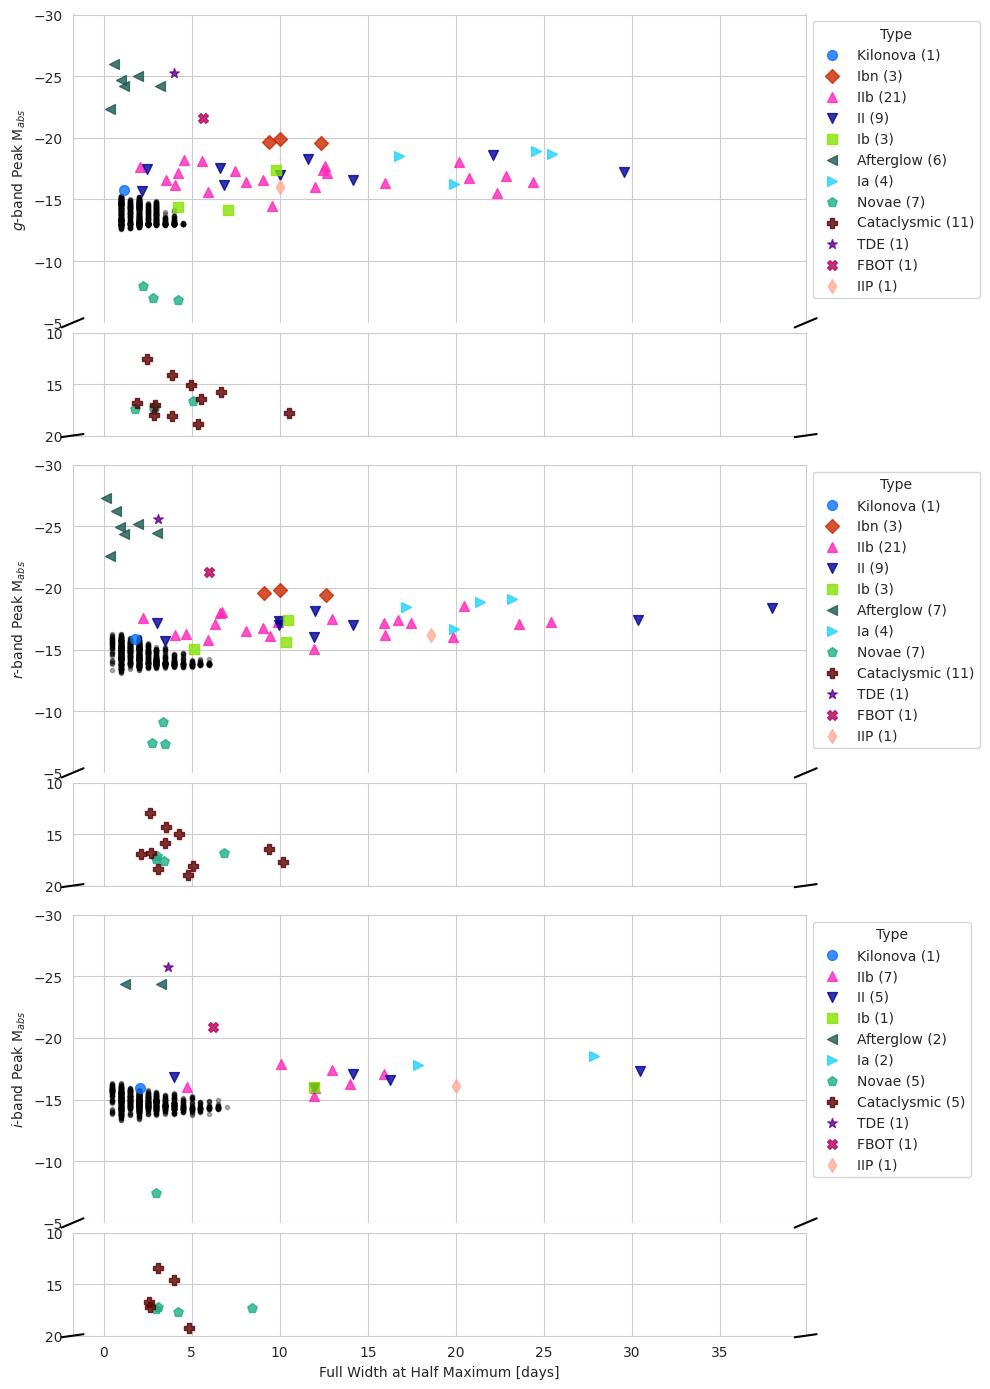

In [33]:
sns.set_style('whitegrid')
filters = ['ztfg', 'ztfr', 'ztfi']

## Create subplots
fig, ax = plt.subplots(3, 1, figsize=(10, 14), sharex=True, sharey=True, tight_layout=True)
axs2 = []

for axi, filter in enumerate(filters):
    ## create broken axis
    divider = make_axes_locatable(ax[axi])
    ax2 = divider.new_vertical(size="300%", pad=0.1)
    fig.add_axes(ax2)
    ax2.sharex(ax[axi])
    axs2.append(ax2)
    ax2.tick_params(bottom=False, labelbottom=False)
    ax2.spines['bottom'].set_visible(False)
    d = .015
    for axis, trans in zip([ax2, ax[axi]], [ax2.transAxes, ax[axi].transAxes]):
        kwargs = dict(transform=trans, color='k', clip_on=False, zorder=100)
        axis.plot((-d, +d), (-d, +d), **kwargs)
        axis.plot((1 - d, 1 + d), (-d, +d), **kwargs)

    ## set axis limits
    ax[axi].set_ylim(20, 10)
    ax2.set_ylim(-5, -30)
    
    ## Scatter plot for bulla 2019 grid
    for axis in [ax[axi], ax2]:
        axis.scatter(df_2019[f'{filter}_fwhm'], df_2019[f'{filter}_peak_mag'], alpha=0.3, color='k', marker='.')

    ## Scatter plot for imposters, separated by type
    for type_ in df_rates['type'].unique():
        df_class = df_rates[(df_rates['type'] == type_) & df_rates[f'{filter}_peak_mag'].notnull() & df_rates[f'{filter}_fwhm'].notnull()]
        if not df_class.empty:
            style = type_style_dict[type_]
            for axis in [ax[axi], ax2]:
                axis.scatter(df_class[f'{filter}_fwhm'], df_class[f'{filter}_peak_mag'], 
                             color=style['color'], marker=style['marker'], s=style['size'], 
                             alpha=style['alpha'], label=type_, zorder=style['zorder'])

## legend for each subplot including a count of each type
for axi, counts in zip(axs2, [df_rates[df_rates[f'{filt}_fwhm'].notnull() & df_rates[f'{filt}_peak_mag'].notnull()]['type'].value_counts().to_dict() for filt in filters]):
    handles, labels = axi.get_legend_handles_labels()
    new_labels = [f'{label} ({counts[label]})' for label in labels if label in counts]
    axi.legend(handles, new_labels, title='Type', bbox_to_anchor=(1, 1), loc="upper left")

## Set labels
axs2[0].set_ylabel("$\it{g}$-band Peak M$_{abs}$")
axs2[1].set_ylabel("$\it{r}$-band Peak M$_{abs}$")
axs2[2].set_ylabel("$\it{i}$-band Peak M$_{abs}$")
ax[2].set_xlabel("Full Width at Half Maximum [days]")
plt.show()
